In [1]:
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from collections import Counter
from multimodal.multimodal_data_module import MultiModalSAYCamDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.lm_lit import LMLitModel
from train import _setup_parser

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [35]:
parser = _setup_parser()
args = parser.parse_args("")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = MultiModalSAYCamDataModule(args)
data.prepare_data()
data.setup()
"""
#checkpoint = "checkpoints/lm_embedding_type_spatial_text_encoder_lstm_dropout_i_0.1_dropout_o_0.1_batch_size_16/epoch=91.ckpt"
checkpoint = "checkpoints/lm_text_encoder_lstm_embedding_dim_32_lr_0.03_dropout_o_0.1_batch_size_128/epoch=20.ckpt"
#checkpoint = "checkpoints/lm_text_encoder_cbow_lr_0.01_crange_3_dropout_o_0.0_batch_size_16/epoch=0.ckpt"
lit_model = LMLitModel.load_from_checkpoint(checkpoint, map_location=device)
text_encoder = lit_model.text_encoder
"""
spatial_embedding_checkpoint = "/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal/checkpoints/multimodal-epoch=99.ckpt"
lit_model = MultiModalLitModel.load_from_checkpoint(spatial_embedding_checkpoint, map_location=device)
text_encoder = lit_model.model.text_embed

vocab = lit_model.vocab
vocab_size = len(vocab)
print(f'vocab_size = {vocab_size}')
for idx in range(vocab_size):
    assert idx in lit_model.idx2word
lit_model.eval()

Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
vocab_size = 5589


MultiModalLitModel(
  (model): MultiModalModel(
    (image_embed): VisionEncoder(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum

In [37]:
from tqdm import tqdm

def get_mean_vectors(cnt_only=False):
    sum_vectors = torch.zeros(vocab_size, text_encoder.hidden_dim, device=device)
    cnt_vectors = torch.zeros(vocab_size, dtype=torch.int, device=device)

    for x, y, y_len in tqdm(data.train_dataloader()):
        y, y_len = y.cuda(), y_len.cuda()
        if not cnt_only:
            outputs = text_encoder(y, y_len)
        for i in range(len(y)):
            for j in range(y_len[i].item()):
                token_id = y[i, j]
                cnt_vectors[token_id] += 1
                if not cnt_only:
                    vector = outputs[i, j].detach()
                    sum_vectors[token_id] += vector

    mean_vectors = sum_vectors / cnt_vectors.unsqueeze(-1)
    vectors = mean_vectors.cpu().numpy()
    for i in range(len(cnt_vectors)):
        if cnt_vectors[i].item() == 0:
            vectors[i].fill(0.)
    return vectors, cnt_vectors

def get_embedding_vectors():
    return text_encoder.embedding.weight.detach().cpu().numpy()

#vectors, cnt_vectors = get_mean_vectors()
_, cnt_vectors = get_mean_vectors(cnt_only=True)
vectors = get_embedding_vectors()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8289/8289 [01:03<00:00, 129.67it/s]


In [54]:
tokens = input().split()
token_ids = []
print('not found:', end='')
for s in tokens:
    try:
        token_ids.append(lit_model.word2idx[s])
    except KeyError:
        print(f' {s}')
print()
np.set_printoptions(precision=2)
V = vectors[token_ids]
V = V / np.linalg.norm(V, axis=1, keepdims=True)
print(V @ V.T)
# do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives
# do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled
# do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling
# do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't
# red orange yellow green blue purple brown black white

do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives stand stands crawl crawls
not found: stands
 crawls

[[1.   0.43 0.27 0.18 0.28 0.21 0.4  0.2  0.44 0.17 0.28 0.13 0.36 0.34
  0.28 0.1  0.14 0.15 0.17 0.27 0.25 0.2 ]
 [0.43 1.   0.09 0.12 0.14 0.2  0.2  0.29 0.28 0.29 0.15 0.23 0.39 0.34
  0.25 0.24 0.16 0.22 0.25 0.24 0.05 0.12]
 [0.27 0.09 1.   0.44 0.29 0.13 0.44 0.15 0.26 0.16 0.31 0.11 0.27 0.16
  0.38 0.2  0.23 0.14 0.34 0.21 0.41 0.37]
 [0.18 0.12 0.44 1.   0.38 0.27 0.22 0.4  0.21 0.33 0.21 0.32 0.11 0.33
  0.2  0.31 0.31 0.28 0.33 0.28 0.45 0.32]
 [0.28 0.14 0.29 0.38 1.   0.35 0.26 0.28 0.34 0.21 0.24 0.12 0.24 0.24
  0.24 0.11 0.3  0.2  0.32 0.18 0.42 0.31]
 [0.21 0.2  0.13 0.27 0.35 1.   0.19 0.42 0.29 0.41 0.18 0.18 0.29 0.49
  0.25 0.22 0.35 0.25 0.35 0.36 0.2  0.3 ]
 [0.4  0.2  0.44 0.22 0.26 0.19 1.   0.44 0.59 0.33 0.56 0.32 0.48 0.36
  0.21 0.25 0.18 0.28 0.42 0.48 0.43 0.39]
 [0.2  0.29 0.15 0.4  0.28 0.42 0.44 1.   0

In [57]:
tokens = input().split()
assert len(tokens) % 2 == 0
token_ids = []
ok = True
print('not found:', end='')
for s in tokens:
    try:
        token_ids.append(lit_model.word2idx[s])
    except KeyError:
        print(f' {s}')
        ok = False
print()
if ok:
    np.set_printoptions(precision=2, suppress=True)
    V = vectors[token_ids]
    V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
    V = V[:, 1] - V[:, 0]
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    print(V @ V.T)
# boy girl mommy daddy grandpa grandma

do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives
not found:
[[ 1.    0.09  0.1   0.25  0.21  0.23 -0.05  0.15  0.04 -0.09]
 [ 0.09  1.    0.03  0.4   0.2   0.31  0.43  0.24  0.05  0.07]
 [ 0.1   0.03  1.    0.17  0.2   0.12  0.23  0.08  0.    0.14]
 [ 0.25  0.4   0.17  1.    0.29  0.47  0.33  0.15 -0.05 -0.08]
 [ 0.21  0.2   0.2   0.29  1.    0.36  0.25 -0.07  0.1  -0.04]
 [ 0.23  0.31  0.12  0.47  0.36  1.    0.19  0.18  0.    0.17]
 [-0.05  0.43  0.23  0.33  0.25  0.19  1.    0.11  0.13  0.07]
 [ 0.15  0.24  0.08  0.15 -0.07  0.18  0.11  1.    0.05  0.04]
 [ 0.04  0.05  0.   -0.05  0.1   0.    0.13  0.05  1.    0.06]
 [-0.09  0.07  0.14 -0.08 -0.04  0.17  0.07  0.04  0.06  1.  ]]


In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage

selected = cnt_vectors.cpu().numpy() >= 50
selected_vectors = vectors[selected]
selected_indices = np.arange(len(vectors))[selected]
n_samples = len(selected_vectors)

Z = linkage(selected_vectors, method='weighted', metric='cosine')

print(Z.shape)

(380, 4)


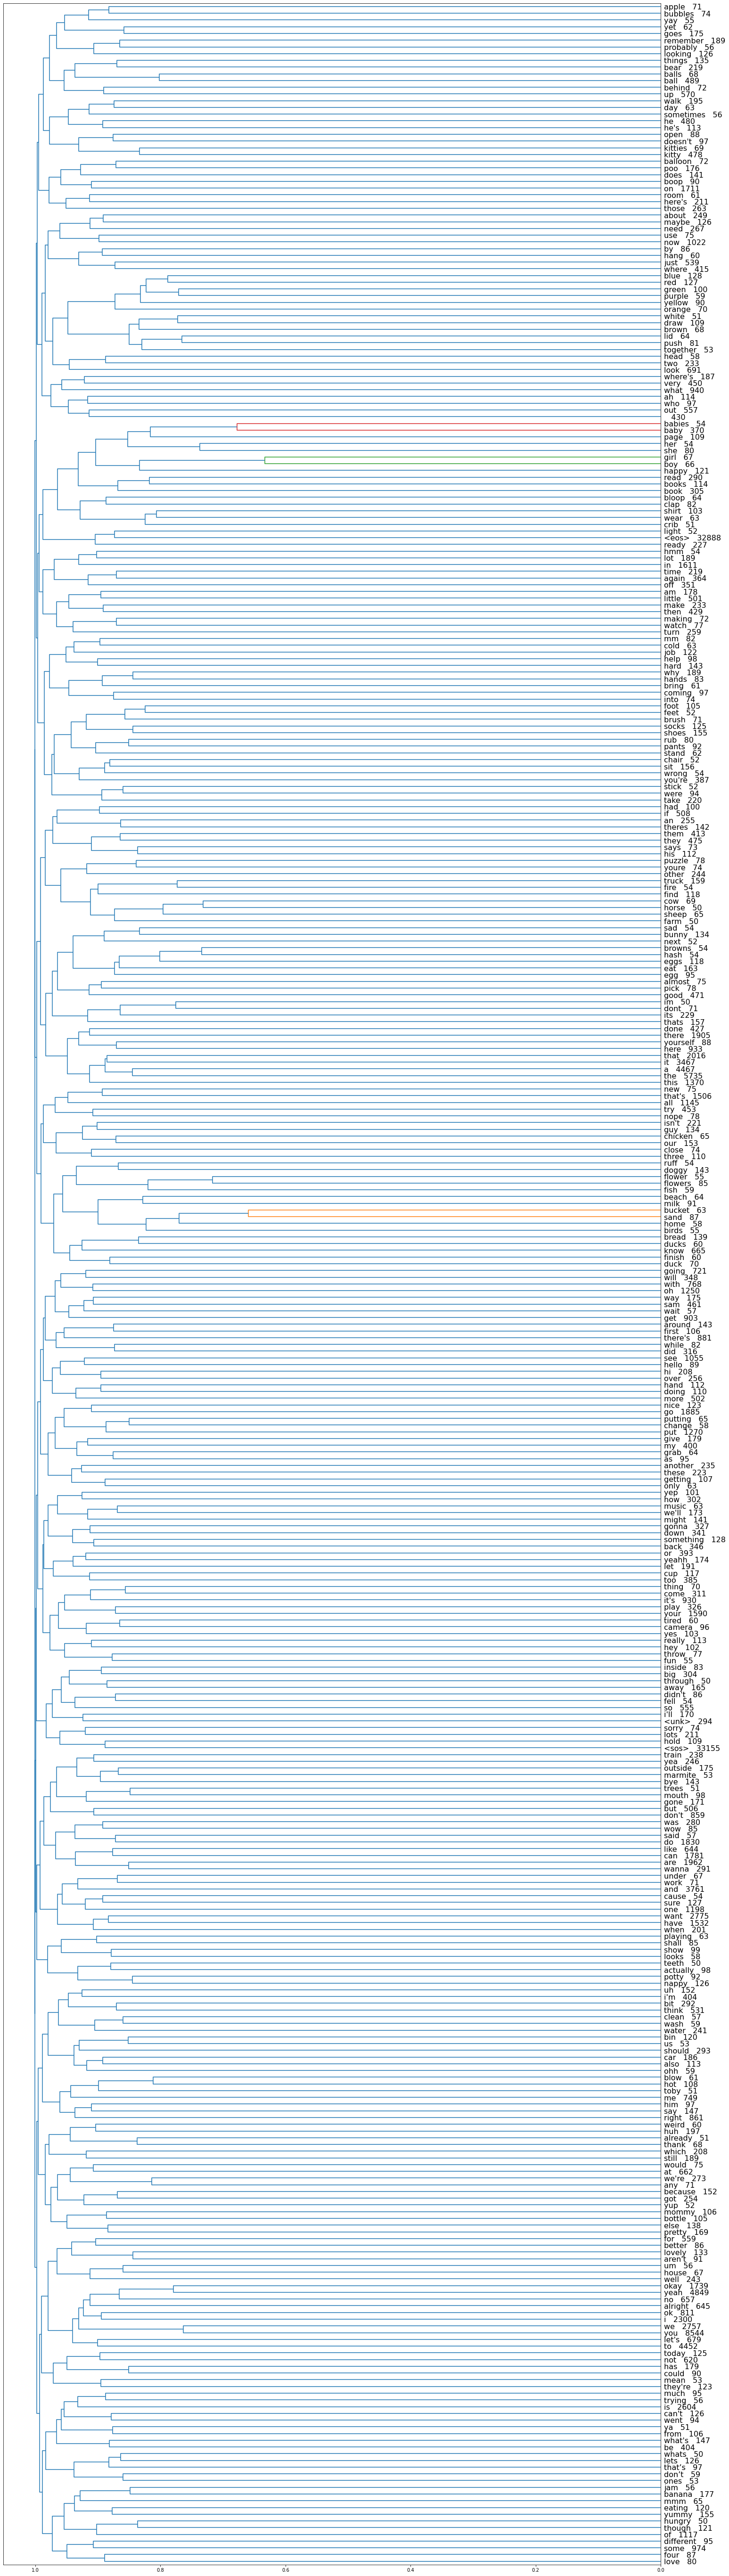

In [45]:
def llf(idx):
    if idx < n_samples:
        idx = selected_indices[idx]
        return lit_model.idx2word[idx] + f'   {cnt_vectors[idx].item()}'
    else:
        return f'{idx - n_samples} {int(Z[idx - n_samples, 3])} {Z[idx - n_samples, 2]:.3f}'

p = 2000

plt.figure(figsize=(25, 0.05 * p)) # 0.1
_ = dendrogram(
    Z,
    #truncate_mode='lastp',
    #p=p,
    orientation='left',
    leaf_rotation=0.,
    leaf_font_size=16.,
    leaf_label_func=llf,
)